# Normed Rg plotter script
#### Updated: Converted to jupyter notebook instead of standalone Python script, no longer need to pickle data or make extra files

## Load libraries and functions

In [74]:
# Import libraries
import flika_JSON_IO as flikaIO
import feature_calculator as fcalc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

## Pre-load relevant functions

In [75]:
# Load and prep data
def prep_flika_normed_Rg_data(main_dir, json_file, frame_cutoff):
    """Generates a dataframe of trajectory data with Rg, and normed_Rg

    Args:
        main_dir (string or Path object): a string or pathlib.Path() object directed to the working directory
        json_file (string): the name, including extension, of the json file to process
        frame_cutoff (int): the number of frames at which to apply a cutoff

    Returns:
        pandas.DataFrame(): dataframe with trajectory positional data in microns, Rg, and normed_Rg
                            Rg is the radius of gyration
                            normed_Rg is Rg divided by the mean step length
    """
    # make the path a pathlib.Path() object
    path_json = Path(main_dir) / json_file
    # converts json file to dataframe with tracks equal to or longer than cutoff value
    json_tracks = flikaIO.json_to_pandas(str(path_json), path_json.stem, frame_cutoff)
    # trim all tracks to be exactly the length of the cutoff and no more
    json_tracks = json_tracks.loc[json_tracks["Frame"] <= 50]
    # cast the correct data types, ID should be int not float
    json_tracks["ID"] = json_tracks["ID"].astype(int)
    # adjust tracks from pixel units to microns
    json_tracks[["X", "Y"]] *= 0.1092
    # calc Rg up to the last frame for each of the tracks
    Rg_lastFrame = fcalc.radGyr_lastFrame(json_tracks)
    # setup new, blank colummns in track dataframe for the Rg data
    json_tracks["Rg"] = np.nan
    json_tracks["normed_Rg"] = np.nan
    # process Rg and normed_Rg for each track
    for trackID in np.arange(0, len(Rg_lastFrame), 1):
        # insert the Rg data into the dataframe
        json_tracks.loc[json_tracks.ID == trackID, "Rg"] = Rg_lastFrame[trackID]
        # grab an individual track
        json_track = json_tracks.loc[json_tracks.ID == trackID][["X", "Y"]].dropna().copy()
        # calc mean step length of individual track
        mean_step_length = np.linalg.norm(json_track[["X", "Y"]].iloc[0:-1].values-json_track[["X", "Y"]].iloc[1:].values, axis=1).mean()
        # insert normed_Rg data into the dataframe
        json_tracks.loc[json_tracks.ID == trackID, "normed_Rg"] = Rg_lastFrame[trackID] / mean_step_length
    return json_tracks

# Plotting function
def plot_normed_rg(working_dir, working_tiff_file, tiff_index, normed_Rg_data, save_plot_dir=None):
    """Plots the trajectory on top of the cell image and colors tracks based on normed_Rg

    Args:
        working_dir (string or Path object): path to the working directory
        working_tiff_file (string): the name, including extension, of the tiff file to process
        tiff_index (int): the 0-index-based position of the image in the stack of tiff images
        normed_Rg_data (pandas.DataFrame): dataframe with trajectory and normed_Rg data
        save_plot_dir (string or Path object, optional): path to output directory for plot. Defaults to None which means plot won't be saved.
    """
    pd.set_option('display.precision', 16)
    path_tiff = Path(working_dir) / working_tiff_file
    # load the tiff stack
    imStack = Image.open(path_tiff)
    imStack.load()
    # extract the dic frame and make a copy
    imStack.seek(tiff_index)
    img_dic = imStack.copy()
    # gather the normed_Rg and range of data
    normed_Rgs = list(normed_Rg_data.groupby("ID")["normed_Rg"].mean())
    Rg_max = max(normed_Rgs)
    Rg_min = min(normed_Rgs)
    # set the colorbar color palette
    cm = plt.get_cmap('jet')
    # autoscale the colorbar for the plotted tracks
    cNorm  = colors.Normalize(vmin=math.floor(Rg_min), vmax=math.ceil(Rg_max))
    # manually scale the colorbar for the plotted tracks
    cNorm  = colors.Normalize(vmin=0, vmax=15)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    # set up the plot based on the pixel size of the image   
    subplot_kw = dict(xlim=(0, 1024), ylim=(1024, 0), autoscale_on=False)
    fig, axes = plt.subplots(1, 1, subplot_kw=subplot_kw, figsize=(10, 7))
    # plot the TIRFM image
    axes.imshow(img_dic, cmap=plt.get_cmap('gray'))
    # plot the tracks on top of the image
    trackID_list = list(normed_Rg_data.ID.unique())
    for trackID in trackID_list:
        track_Rg = normed_Rgs[trackID]
        indivTrack_df = normed_Rg_data.loc[normed_Rg_data['ID'] == trackID, ['X', 'Y']]
        colorValue = scalarMap.to_rgba(track_Rg)
        plt.plot(indivTrack_df.X, indivTrack_df.Y, color=colorValue, linewidth=1)
    totalTracks = len(normed_Rgs)
    # adjust position and details of color bar
    cbax = fig.add_axes([0.85, 0.12, 0.05, 0.78])
    cb = mpl.colorbar.ColorbarBase(cbax, cmap=cm, norm=cNorm, orientation='vertical')
    cb.set_label("Normed Rg Values", rotation=270, labelpad=15, fontsize=14)
    # autoscale the legend colorbar
    colorbar_Side = np.arange(math.floor(Rg_min), math.ceil(Rg_max)+1, 1)
    # manually scale the legend colorbar
    colorbar_Side = np.arange(0, 16, 1)
    cb.set_ticks(colorbar_Side)
    # set all the plot labels
    plt.suptitle(f'{path_tiff.stem}')
    plt.title(f'Total Tracks: {totalTracks}')
    # clean up the layout before display or saving
    fig.tight_layout(rect=[0, 0, 1, .95])
    if save_plot_dir:
        plt.savefig(save_plot_dir + path_tiff.stem + '_normed_Rg-Overlay.png', bbox_inches='tight')
    plt.show()

## User Inputs

In [76]:
# User inputs

# Directory with json and tiff file in it
working_dir = r"C:\Users\User\OneDrive\Documents\Python Programs\Piezo1-Rg-Overlay-Plotting\JSON_example_file"
# Name of current json file to use
working_json_file = "GB_221_Halo_B2.json"
# Name of corresponding tiff file
working_tiff_file = ""
# Index of tiff file image to use
tiff_index = 0
# Frame cutoff value
min_frm = 50

# If you include a directory as an argument, the plot will be saved there
output_plots_dir = None

In [77]:
tester = prep_flika_normed_Rg_data(working_dir, working_json_file, min_frm)

<AxesSubplot:>

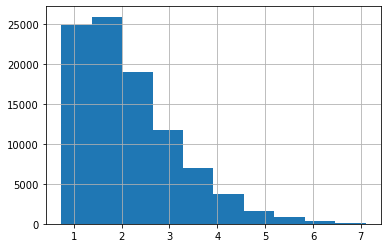

In [78]:
tester.normed_Rg.hist()

## Plotting

## Testing & Troubleshooting